# SWIFT VS SWALLOW
> Phân loại chim yến (swift) và chim én (swallow)
> Trong dự án này, tôi chỉ sử dụng các kiến trúc đã được "học" -train rồi và tận dụng lại các biến (parameters) được cải thiện chất lượng. Việc tự thiết kế một kiến trúc mới và thử nghiệm theo quan điểm cá nhân tôi là chưa phù hợp ở thời điểm hiện tại, do các vấn đề về độ lớn của dữ liệu (dữ liệu tôi sử dụng rất nhỏ), thời gian xử lý và cách cải thiện biến (fine-tune parameters) là rất phức tạp để thực hiện. Do vậy, tôi sẽ sử dụng các "pre-trained" models để giải quyết bài toán của mình. 

In [1]:
from fastai.vision.all import *

In [2]:
!ls

download.ipynb	fastai_model.ipynb


In [3]:
## Assign a path to our data:
home = '/path/to/your/project'
path = Path(f"{home}/swift_swallow/data/")

In [4]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('models'),Path('test')]

In [5]:
## Check torch device:
torch.cuda.current_device()

0

## TẠO DỮ LIỆU
Đối với máy học sâu (deep learning - viết tắt DL), việc tạo tập dữ liệu là rất quan trọng để đảm bảo những yếu tố như:
1. Dữ liệu đầu vào phù hợp với kiến trúc được sử dụng (ví dụ: các mô hình pretrained kinh điển - resnet, vgg, googlenet... đều sử dụng dữ liệu hình ảnh với chiều dài, rộng là 224, một số kiến trúc mới sử dụng 256, 299, hoặc lớn hơn như 528, 600 - B6, B7 EfficientNet. Tất nhiên cũng có các kích cỡ nhỏ hơn như 16, 32).
2. Batch-size: số lượng hình ảnh được sử dụng cho một lần học (iteration). Tùy thuộc vào độ lớn của dữ liệu vs dung lượng của GPU của máy tính bạn sử dụng và độ lớn của model bạn sử dụng, batch-size của bạn có thể ảnh hưởng đến tốc độ/khả năng học của model. Các size cơ bản hay được sử dụng là 32, 64, tuy nhiên bạn có thể thu nhỏ hoặc làm to hơn số lượng này (8, 16 hoặc 128...). Một số điểm cần lưu ý giữa các cụm từ: batch-size (bs), iterations (iter), epoch trong DL:
    - epoch: 1 epoch là một lần model học toàn bộ số lượng ảnh trong tập dữ liệu - train/valid - của bạn (giả sử là tập dữ liệu train có n hình ảnh, 1 epoch chứa n hình ảnh)
    - batch-size: 1 bs là số lượng hình ảnh được sử dụng cho từng lần học dữ liệu của model. Do dữ liệu tất cả các hình ảnh là lớn nên model sẽ không thể học đồng thời được mà phải chia nhỏ thành từng giỏ (batch) để học dần. 
    - interation: 1 iteration là 1 lần học dữ liệu của model. Như vậy, 1 iteration tương ứng với 1 bath-size.
    
    như vậy nếu quy ra số lần học dữ liệu (iteration), thì 1 epoch sẽ được tính như sau:
       $epoch = round-up(\frac{n}{batch-size})$ interations
3. Augmentation: dữ liệu hình ảnh có thể được biến đổi như: xoay chiều (rotate), lật (flip), đổi độ sáng, tương phản (brightness, contrast), ...Chúng ta có thể định nghĩa sẵn các bước biến đổi này khi tạo tập dữ liệu.

### Sử dụng ImageDataLoaders

In [8]:
??ImageDataLoaders

Init signature: ImageDataLoaders(*loaders, path='.', device=None)
Source:        
class ImageDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for computer vision problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, **kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_image_files if valid_pct else partial(get_image_files, folders=[train, valid])
        dblock = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
                           get_items=get_items,
                           splitter=splitter,
                           get_y=p

In [10]:
bs = 32
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42, 
    bs=bs,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
)

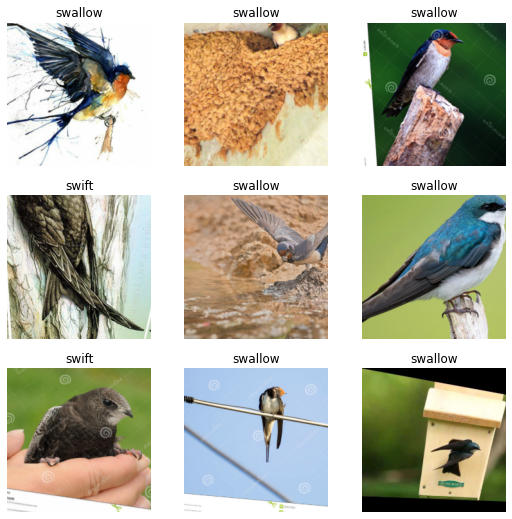

In [11]:
dls.show_batch(max_n=9)

**Diễn giải:**

ImageDataLoaders là một phương pháp tạo ra danh sách (interator) dữ liệu để thực việc học model. Ở đây, chúng ta sử dụng phương thức tạo danh sách dữ liệu từ folder chưa dữ liệu (`from_folder`). Thực thể này bao gồm các giá trị (properties) sau:

- path: là nơi (folder) chứa dữ liệu. Folder này được cấu trúc dưới dạng hierarchy như: train/test/valid --> tên các nhãn (classes) (ở đây chúng ta có folder con là swift và swawllow).
- train/valid: bạn có thể cấu trúc folder cho tập train/valid theo cách mà các thử thách ở Kaggle thường sắp xếp. Trong trường hợp này, chúng ta không có tập valid (ko có folder valid) nên sẽ không điền thông tin này. Thay vào đó chúng ta sẽ điền thông tin về `valid_pct` để lấy % của tập train làm valid.
- bs: batch-size, ở đây, bs mặc định là 64, tuy nhiên tôi đã chọn là 32 vì GPU của tôi khá khiêm tốn để chạy được model lớn như ResNet100 chẳng hạn. Khi bạn sử dụng bs từ 64 trở lên, nếu dùng GPU <= 8GB, bạn có thể bị tràn bộ nhớ GPU và cần phải restart lại notebook. Khi đó, hay giảm size của bs hoặc sử dụng các arc có kích thước nhỏ hơn (ResNet34, ResNet50 chẳng hạn).
- item_tfms: đây là biến đổi ảnh cho từng ảnh. Ở đây tôi chỉ sử dụng resize lại ảnh về cỡ 460 để thuận tiện hơn cho các bước augmentation tiếp theo cho từng batch một. Do kinh nghiệm của mình còn khiêm tốn nên tôi chưa thực sự nắm được lý do cho việc sử dụng cả `item_tfms` và `batch_tfms` ở đây. Theo như lý giải của tác giả, việc thực hiện biến đổi hình ảnh được thông qua 2 bước:
    + Bước 1: mở rộng dung size của ảnh (resize sang cỡ ảnh đủ lớn)
    + Bước 2: thao tác biến đổi ảnh khác nhau theo từng batch. 
    Theo tác giả thì theo cách biến đổi này, kết quả của việc biến đổi ảnh theo từng batch sẽ cho kết quả về chất lượng hình ảnh được tốt hơn so với cách thông thường là biến đổi ảnh trực tiếp từ ảnh. Một số lỗi hay gặp khi biến đổi trực tiếp từ ảnh như:
    + Ảnh sau biến đổi bị mất ảnh (ảnh sau biến đổi phải bổ sung thêm nền đen (padding zero)
    + Chất lượng ảnh (resolution) không thật sự tốt, ảnh bị mờ nhiều hơn
    + Ảnh khi xoay chiều có thể không được như ý.
    Thông tin chi chiết về cách phương pháp augmentation, xin xem tại [đây](https://docs.fast.ai/vision.augment)
- batch_tfms: đây là các bước biến đổi ảnh chính được thực hiện cho từng batch hình ảnh khi được học. Các bước biến đổi này có thể được thực hiện trên GPU để tăng tốc độ biến đổi. Ở đây tôi sử dụng resize về cỡ 224 và sử dụng tất cả các bước biến đổi ảnh mặc định. Ngoài ra, có biến đổi normalize lại các pixcel ảnh. 

Ngoài phương thức tạo dữ liệu từu folder, ImageDataLoads còn có các phương thức tạo dữ liệu khác như:
- from_name_func: Chúng ta có thể tạo 1 hàm lambda để tạo thu thập nhãn dựa vào tên của ảnh, trong đó, các nhãn được gắn với tên của hình ảnh. Ví dụ như: ảnh swift-train-12346.jpg được đặt ở trong folder data. 
- from_path_func: tương tự như trên nhưng áp dụng với đường dẫn.
- from_path_re: sử dụng regex để lấy được thông in về tập train/test/valid và nhãn từ đường dẫn tới ảnh.
- from_name_re: tương tự như trên nhưng áp dụng cho tên của ảnh.
- from_df: trong dữ liệu có một bảng dữ liệu chứa thông tin về đường dẫn của từng file ảnh thuộc tập train/test/valid và tương ứng với từng đường dẫn này là nhãn của ảnh. 
- form_csv: tương tự với from_df trong đó file chứa thông tin này được lưu dưới dạng csv.
- from_lists: tương tự dạng csv nhưng thông tin về đường dẫn, nhãn được lưu dưới dạng list.

### Sử dụng DataBlock

DataBlock là API xây dựng dataset và DataLoader. Với DataBlock, bạn có thể xây dựng dataset một cách tùy biến cho tất cả các loại dữ liệu của bạn như: hình ảnh (image), bảng biểu (tabular) hay chữ (text). Tất nhiên, điều này đồng nghĩa với việc bạn cần nắm rõ hơn được dữ liệu của bạn là gì, cách thức bạn muốn xây dựng tập dữ liệu của bạn. Bản thân tôi cũng còn rất mới mẻ về DL nên phần thông tin này sẽ đi qua các thông tin chính mà DataBlock yêu cầu:
1. Loại dữ liệu đầu vào/ra. 
2. Phương pháp nhặt, phân nhóm và gán nhãn dữ liệu .
3. Phương pháp biến đổi dữ liệu (nếu có)

- Getting the source items,
- Splitting the items into the training set and one or more validation sets,-
- Labelling the items,
- Processing the items (such as normalization), and
- Optionally collating the items into batches

Xây dựng DataLoader:

In [21]:
doc(get_image_files)

get_image_files [source] get_image_files ( path , recurse = True , folders = None ) 
 
 Get image files in path recursively, only in folders , if specified. 
 Show in docs

In [13]:
bird_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
)
dls = bird_db.dataloaders(path)

In [22]:
## Bạn có thể cài thêm gói nbdev để xem được phần tài liệu của các lớp, hàm:
#!pip install nbdev
doc(ImageBlock)

ImageBlock [source] ImageBlock () 
 
 A TransformBlock for images of cls 
 Show in docs

**Diễn giải:**

1. Loại dữ liệu đầu vào/ra:
    - `blocks`: được sử dụng để xác định loại dữ liệu đầu vào và ra - mục đích sử dụng của loại dữ liệu này (x và y!). Trong đó `ImageBlock` là dữ liệu đầu vào dạng ảnh, còn `CategoryBlock` là dữ liệu đầu ra dạng phân loại. 

2. Phương pháp nhặt, phân nhóm và gán dữ liệu:
    - `get_items`: phương pháp nhặt dữ liệu, chúng ta sử dụng hàm `get_image_files` ở đây làm phương pháp nhặt dữ liệu dạng hình ảnh. Phương pháp này hỗ trợ việc phân loại hình ảnh theo nhóm (train/valid) nếu như folder có đặt chi tiết thành train và valid riêng biệt. Nếu không, bạn có thể chỉ chi tiết cách  phân nhóm hoặc DataBlock sẽ mặc định lấy 20% dữ liệu của bạn để làm tập valid.
    - `get_y`: phương pháp gán nhãn, sử dụng hàm `parent_label` để sử dụng folder mẹ làm nhãn của hình ảnh (có nghĩa là tất cả các ảnh được chứa trong cùng một folder ngay trên nó (folder mẹ) thì tên folder đó chính là nhãn của hình ảnh.
3. Phương pháp biến đổi dữ liệu:
    - `item_tfms`: phương pháp biến đổi dữ liệu cho từng ảnh
    - `batch_tfms`: phương pháp biến đổi dữ liệu cho từng batch một.
    

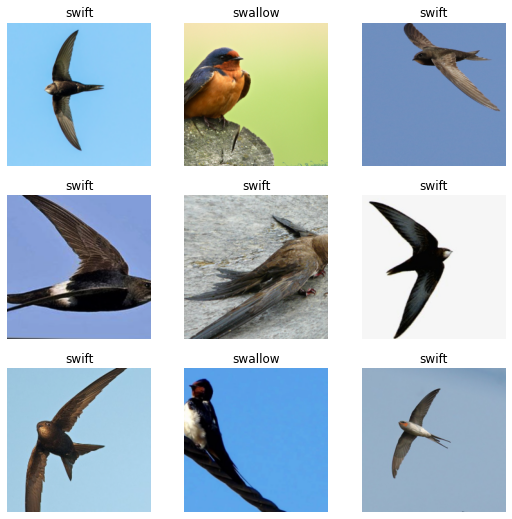

In [14]:
## Kiểm tra dữ liệu:
dls.show_batch(max_n=9)

Chúng ta cũng có thể xem thêm thông tin về các bước biến đổi dữ liệu cũng như các thông số:

In [8]:
print(imagenet_stats)

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [9]:
print(*aug_transforms(size=224, min_scale=0.75))

Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes:  Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes:  RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: 


Tạm thời chúng ta có thể sử dụng dữ liệu này để xây dựng mô hình. Hay tiếp tục với các phần sau!

## Đào tạo với RESNET

Resnet là kiến trúc DL rất nổi tiếng và được fastai sử dụng làm kiến trúc được đào tạo trước (pre-trained) chủ đạo. Ngoài ra, còn có biến thể của Resnet cũng được xây dựng sẵn trên fastai. Chúng ta sẽ cùng đi qua vài ví dụ để có thể làm quen dần với các kiến trúc đã được đào tạo trước.

### RESNET34

We'll going to use pretrained model (which is resnet34 here) to train our data. This is big help for us since we dont have to do 2 things: 

1) create a new deep learning architecture every time we train new dataset of new prolem. 
2) fine-tuning architecture (weights of the arc).

Both of these tasks are time-consumming. However, if we can reused state-of-the art arcs with our similar problems, we'd be more accurate and of-course saving tone of our time.

In [10]:
## Create a learner based on ccn_learner method:
learner = cnn_learner(dls, resnet34, metrics=error_rate)

**NOTE:**

Here we create a cnn_learner (convolutional neural network) which is type of deep learning architure that is mostly used for image problems. There a number of things we need to know about this learner:

- dls: dataloader object
- architecture: pretrained model. Here we train with resnet34. If this architecture is not pretrained (we design), we'll need to defind it first, then we'll have to turn of `pretrained` hyperparameter to False in this case.
- metrics: metrics (score) we used to evaluate result of model.
- loss function: here we ignore loss function, however, we'll always need to know what sort of loss function to be use in each case. With binary classification, we'll used binary-cross-entropy loss function. 


In [14]:
## check architecture of the model:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
## after few run tests, we find that 11 epochs would be most benefit for the model.
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.159122,0.579230,0.234973,00:07
1,0.916244,0.295984,0.120219,00:04
2,0.711527,0.231177,0.071038,00:04
3,0.576708,0.235533,0.065574,00:04
4,0.480765,0.222460,0.076503,00:04
5,0.402606,0.229840,0.076503,00:04
6,0.346476,0.211017,0.071038,00:04
7,0.305634,0.207157,0.071038,00:04
8,0.273661,0.204828,0.065574,00:04
9,0.245254,0.202186,0.065574,00:04


In [12]:
## save result:
learner.save('stage-1')

Path('models/stage-1.pth')

### Check results:

In [13]:
interp = ClassificationInterpretation.from_learner(learner)
losses, idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)

True

In [18]:
?ClassificationInterpretation

Init signature: ClassificationInterpretation(dl, inputs, preds, targs, decoded, losses)
Docstring:      Interpretation methods for classification models.
File:           ~/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/interpret.py
Type:           type
Subclasses:     


In [20]:
??ClassificationInterpretation.from_learner

Signature:
ClassificationInterpretation.from_learner(
    learn,
    ds_idx=1,
    dl=None,
    act=None,
)
Source:   
    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None))
File:      ~/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/interpret.py
Type:      method


**NOTE:**

In this case, to check results, we'll use ClassificationInterpretation class and its sub-method from_learner to gain all stats from the learner that we've just finished training. And we have a object of interpretation to find more information about it. 

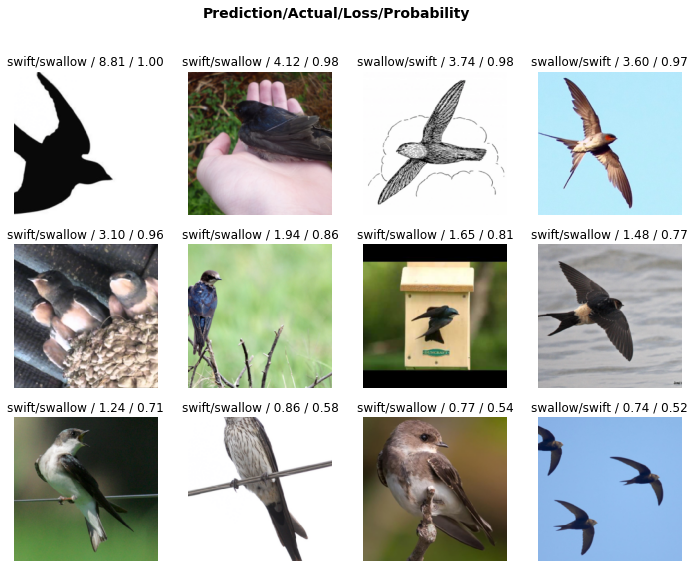

In [16]:
## plot top losses:
interp.plot_top_losses(12)

**NOTE ON LOSSES:**

It looks as if most swallows sit on branches and thus, the model mostly predict bird sitting on braches as swallow. While most swifts fly with wings open wide. Thus, model predicts that most birds fly with open wings are swifts. Some mis-predicted with swallow & swift baby birds.

In [23]:
doc(interp.plot_top_losses)

Interpretation.plot_top_losses [source] Interpretation.plot_top_losses ( k , largest = True , ** kwargs ) 
 
 Show in docs

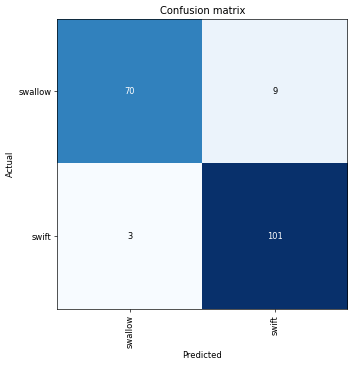

In [15]:
## we further want to check it's score:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Unfreezing Pre-trained model, fine-tuning and learning-rate

In [17]:
learner.unfreeze()
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.835648,5.448223,0.382514,00:05


It doesn't look good with new train results after unfreezing pre-trained model.
Let's further find best learning rate here:

In [21]:
learner.load("stage-1")

**NOTE:**

the next step is to find the efficient learning rates that 

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=9.12010818865383e-07)

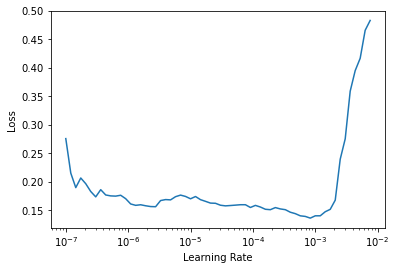

In [22]:
## find best learnig rate:
learner.lr_find()

After finding the right learning rate, let's unfreez it again and retrain it. This time, based on the learning rate finder, we'll slice learning rate between 2e-6 to 1e-4.

In [23]:
learner.unfreeze()
learner.fit_one_cycle(6, lr_max=slice(1e-6,8e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.140789,0.224944,0.060109,00:05
1,0.155556,0.288861,0.060109,00:05
2,0.158139,0.274033,0.081967,00:05
3,0.150515,0.267715,0.087432,00:05
4,0.137551,0.256441,0.076503,00:04
5,0.119532,0.256001,0.071038,00:04


**NOTE:**

It looks like the results look better here. Let's have 6 more circle to see how it'll go, if it's not good, let's reload stage-1 and unfreeze model and fit with less cycles.

In [34]:
# learner.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.121329,0.281597,0.085714,00:07
1,0.108418,0.283750,0.085714,00:06
2,0.109942,0.288984,0.091429,00:06
3,0.096244,0.286599,0.091429,00:06
4,0.089894,0.279662,0.091429,00:06
5,0.092233,0.277769,0.097143,00:06


In [24]:
## Save model after unfreeze layers and retrain weights:
learner.save("stage-2")

Path('models/stage-2.pth')

**RE-INTERPRETE THE RESULTS:**

In [25]:
interp_stg2 = ClassificationInterpretation.from_learner(learner)

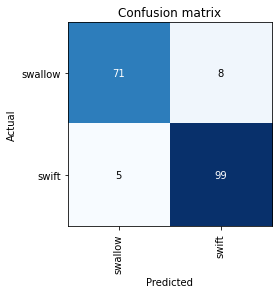

In [26]:
interp_stg2.plot_confusion_matrix()

In [27]:
##accuracy:
(84+87)/(84+87+5+7)

0.9344262295081968

## RESNET-50

In [34]:
learner = cnn_learner(dls, resnet50, metrics=error_rate)

In [35]:
## fit_one_cycle:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.965112,0.433052,0.131148,00:06
1,0.721527,0.260041,0.136612,00:06
2,0.554176,0.160182,0.060109,00:06
3,0.421401,0.186642,0.071038,00:12
4,0.341353,0.222586,0.071038,00:25
5,0.280021,0.191756,0.076503,00:12
6,0.233592,0.174829,0.071038,00:09
7,0.196609,0.168585,0.076503,00:07


In [36]:
learner.save("stage1-50")

Path('models/stage1-50.pth')

**Find lr:**

In [33]:
??learner.lr_find

Signature:
learner.lr_find(
    start_lr=1e-07,
    end_lr=10,
    num_it=100,
    stop_div=True,
    show_plot=True,
    suggestions=True,
)
Source:   
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if show_plot: self.recorder.plot_lr_find()
    if suggestions:
        lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
        if len(losses) == 0: return
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        return SuggestedLRs(lr_min/10.,lr_steep)
File:      

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=2.75422871709452e-06)

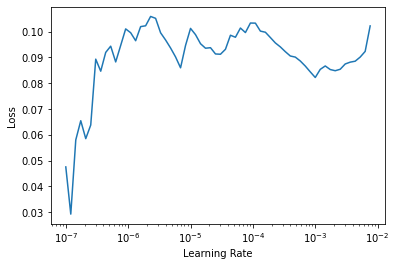

In [37]:
learner.lr_find()

In [37]:
learner.unfreeze()
learner.fit_one_cycle(10, lr_max=slice(6.309573450380412e-07, 0.00043651582673192023))

epoch,train_loss,valid_loss,error_rate,time
0,0.107520,0.220684,0.060109,00:07
1,0.106791,0.267370,0.071038,00:07
2,0.092749,0.272470,0.065574,00:07
3,0.077462,0.214519,0.049180,00:07
4,0.065444,0.239370,0.049180,00:07
5,0.067952,0.207074,0.038251,00:07
6,0.060400,0.189691,0.049180,00:07
7,0.058598,0.186252,0.038251,00:07
8,0.053605,0.183891,0.038251,00:07
9,0.059856,0.192166,0.043716,00:07


In [38]:
learner.save("stage2-50")

Path('models/stage2-50.pth')

In [39]:
interp = ClassificationInterpretation.from_learner(learner)

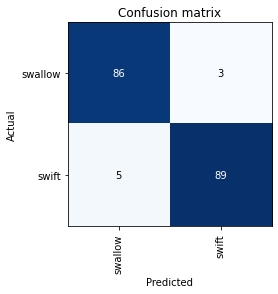

In [40]:
interp.plot_confusion_matrix()

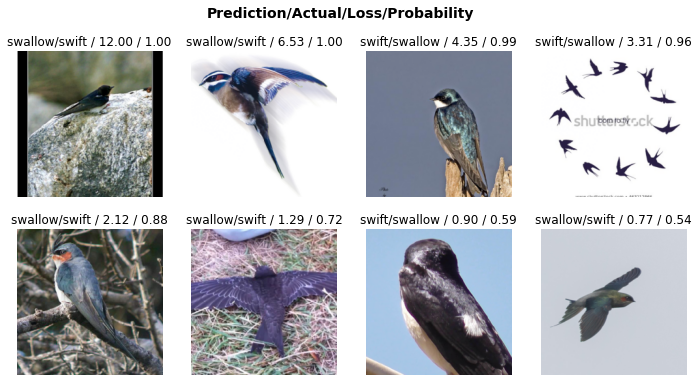

In [41]:
interp.plot_top_losses(8)

**NOTE:**
we can see that it's hard to recognize treeswifts and barn swallow at some views since they have similar shape when they're standing and similar flying style as well.

Let's try some other architectures (newly developed by fastai: xresnet; xresent-deep & xresnet-deeper to see any differences they make to this.

In [43]:
learner.save('stage2-50')

Path('models/stage2-50.pth')

# xRESNET:

In [10]:
learner = cnn_learner(dls, xresnet50, metrics=error_rate)

In [7]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.104483,0.665283,0.278689,00:07
1,0.889694,0.648838,0.224044,00:05
2,0.845206,0.605756,0.229508,00:05
3,0.763565,0.548696,0.234973,00:05
4,0.672988,0.513306,0.191257,00:06
5,0.638785,0.471807,0.202186,00:06
6,0.577574,0.430423,0.169399,00:05
7,0.532678,0.451786,0.185792,00:05
8,0.486897,0.443982,0.202186,00:05
9,0.464668,0.451145,0.185792,00:05


In [8]:
interp = ClassificationInterpretation.from_learner(learner)

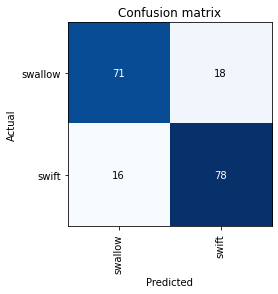

In [9]:
interp.plot_confusion_matrix()

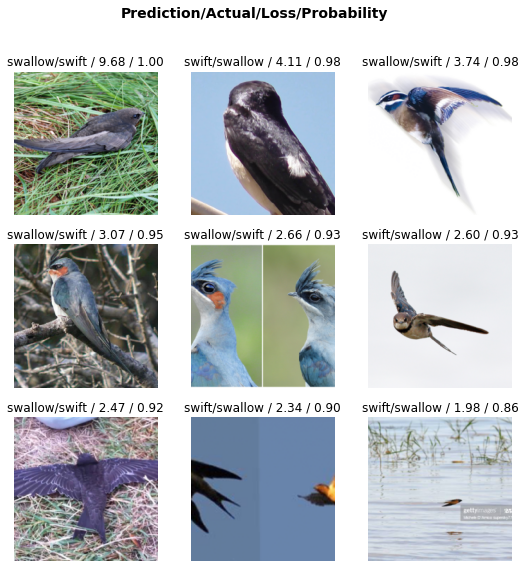

In [10]:
interp.plot_top_losses(9)

In [11]:
learner.save("stage1-x50")

Path('models/stage1-x50.pth')

In [11]:
learner.load("stage1-x50")

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=1.0964781722577754e-06)

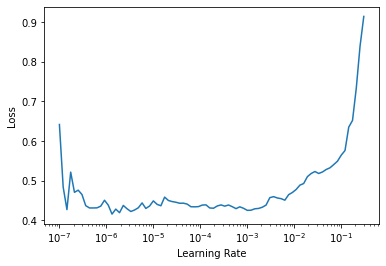

In [12]:
learner.lr_find()

In [13]:
learner.unfreeze()
learner.fit_one_cycle(6, lr_max=slice(9.12010818865383e-07, 1.318256749982538e-07))    

epoch,train_loss,valid_loss,error_rate,time
0,0.438584,0.439873,0.185792,00:08
1,0.427765,0.438531,0.185792,00:07
2,0.431225,0.441008,0.196721,00:07
3,0.418932,0.435654,0.185792,00:07
4,0.421612,0.434449,0.185792,00:07
5,0.422202,0.436851,0.185792,00:07


Based on the training, it doesn't look like xRESNET is good use.

Let's try deep & deeper xRESNET

In [14]:
learner = cnn_learner(dls, xresnet50_deep, metrics=error_rate)

In [22]:
learner.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.234699,0.726292,0.371585,00:06
1,1.113659,0.814082,0.284153,00:06
2,1.025010,1.097317,0.344262,00:06
3,0.916635,0.813829,0.311475,00:05
4,0.817120,0.633078,0.295082,00:05
5,0.779663,0.723271,0.284153,00:05
6,0.727677,0.722286,0.300546,00:05
7,0.657205,0.735125,0.300546,00:05
8,0.595359,0.605385,0.267760,00:05
9,0.553759,0.669066,0.289617,00:05


In [15]:
learner.save("stage1-x50_deep")

Path('models/stage1-x50_deep.pth')

In [23]:
learner.load("stage1-x50_deep")

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.10.0.convpath.0.0.weight", "0.10.0.convpath.0.1.weight", "0.10.0.convpath.0.1.bias", "0.10.0.convpath.0.1.running_mean", "0.10.0.convpath.0.1.running_var", "0.10.0.convpath.1.0.weight", "0.10.0.convpath.1.1.weight", "0.10.0.convpath.1.1.bias", "0.10.0.convpath.1.1.running_mean", "0.10.0.convpath.1.1.running_var", "0.10.0.convpath.2.0.weight", "0.10.0.convpath.2.1.weight", "0.10.0.convpath.2.1.bias", "0.10.0.convpath.2.1.running_mean", "0.10.0.convpath.2.1.running_var", "0.11.0.convpath.0.0.weight", "0.11.0.convpath.0.1.weight", "0.11.0.convpath.0.1.bias", "0.11.0.convpath.0.1.running_mean", "0.11.0.convpath.0.1.running_var", "0.11.0.convpath.1.0.weight", "0.11.0.convpath.1.1.weight", "0.11.0.convpath.1.1.bias", "0.11.0.convpath.1.1.running_mean", "0.11.0.convpath.1.1.running_var", "0.11.0.convpath.2.0.weight", "0.11.0.convpath.2.1.weight", "0.11.0.convpath.2.1.bias", "0.11.0.convpath.2.1.running_mean", "0.11.0.convpath.2.1.running_var". 

SuggestedLRs(lr_min=5.754399353463669e-07, lr_steep=7.585775847473997e-07)

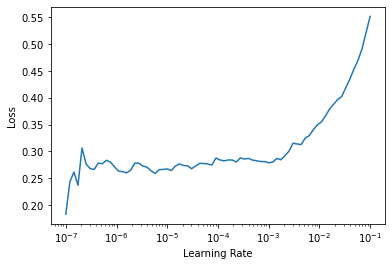

In [22]:
learner.lr_find()

In [17]:
learner.unfreeze()
learner.fit_one_cycle(10, lr_max=slice(1.0964781722577754e-06, 0.0003019951749593019))

epoch,train_loss,valid_loss,error_rate,time
0,1.236704,0.720743,0.333333,00:07
1,1.050963,0.719384,0.289617,00:07
2,0.990046,0.801886,0.322404,00:07
3,0.878589,0.678884,0.278689,00:07
4,0.822276,0.729805,0.278689,00:07
5,0.803536,0.592342,0.267760,00:07
6,0.755065,0.605545,0.251366,00:07
7,0.702199,0.624822,0.251366,00:07
8,0.649588,0.612735,0.262295,00:07
9,0.621836,0.624145,0.284153,00:07


In [18]:
learner = cnn_learner(dls, xresnet50_deeper, metrics=error_rate)

In [20]:
learner.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,0.465155,0.625097,0.273224,00:06
1,0.450099,0.606127,0.278689,00:06
2,0.476388,0.603168,0.240437,00:05
3,0.507000,0.725743,0.349727,00:06
4,0.516499,0.674369,0.240437,00:06
5,0.496295,0.673164,0.234973,00:05
6,0.489760,0.768032,0.278689,00:05
7,0.486999,0.644809,0.267760,00:06
8,0.468935,0.759174,0.240437,00:06
9,0.459300,0.726533,0.240437,00:05
